In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Statistics 

  Activating project at `c:\CMU\SEM II\OCRL\16745---Optimal-Control-and-Reinforcement-Learning---Spring-2025\HW3_S25`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","planar_quadrotor.jl"))

check_dynamic_feasibility (generic function with 1 method)

# Q3: Quadrotor Reorientation (40 pts)

In this problem, you will use the trajectory optimization tools you have demonstrated in questions one and two to solve for a collision free reorientation of three planar quadrotors. The planar quadrotor (as described in lecture 10) is described with the following state and dynamics: 

$$\begin{align} x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \end{bmatrix}, &\quad \quad  \end{align} \dot{x} = \begin{bmatrix}v_x \\ v_z \\ \omega \\ \frac{1}{m}(u_1 + u_2)\sin\theta \\ \frac{1}{m}(u_1 + u_2)\cos\theta \\ \frac{\ell}{2J}(u_2 - u_1)\end{bmatrix} $$ 

where $p_x$ and $p_z$ are the horizontal and vertial positions, $v_x$ and $v_z$ are the corresponding velocities, $\theta$ for orientation, $\omega$ for angular velocity, $\ell$ for length of the quadrotor, $m$ for mass, $g$ for gravity acceleration in the $-z$ direction, and a moment of inertia of $J$. 

You are free to use any solver/cost/constraint you would like to solve for three collision free, dynamically feasible trajectories for these quadrotors that looks something like the following:

<div>
<img src="attachment:quadrotor_reorient.gif" width="500"/>
</div>

(if an animation doesn't load here, check out `quadrotor_reorient.gif`.) 

Here are the performance requirements that the resulting trajectories must meet: 

- The three quadrotors must start at `x1ic`, `x2ic`, and `x2ic` as shown in the code (these are the initial conditions).

- The three quadrotors must finish their trajectories within **.2** meters of `x1g`, `x2g`, and `x2g` (these are the goal states). 

- The three quadrotors must never be within **0.8** meters of one another (use $[p_x,p_z]$ for this).

There are two main ways of going about this:

1. **Cost Shaping**: Design cost functions for each quadrotor that motivates them to take paths that do not result in a collision. You can do something like designing a reference trajectory for each quadrotor to use in the cost. You can use iLQR or DIRCOL for this.  

2. **Collision Constraints**: You can optimize over all three quadrotors at once by creating a new state $\tilde{x} = [x_1^T,x_2^T,x_3^T]^T$ and control $\tilde{u} = [u_1^T,u_2^T,u_3^T]^T$, and then directly include collision avoidance constraints.  In order to use constraints, you must use DIRCOL (at least for now). 

### Hints

- You should not use `norm() >= R` in any constraints, instead you should square the constraint to be `norm()^2 >= R^2`. This second constraint is still non-convex, but it is differentiable everywhere. 

- If you are using DIRCOL, you can initialize the solver with a "guess" solution by linearly interpolating between the initial and terminal conditions. Julia let's you create a length N linear interpolated vector of vectors between `a::Vector` and `b::Vector` like this: `range(a, b, length = N)` (experiment with this to see how it works). 

You can use either RK4 (iLQR or DIRCOL) or Hermite-Simpson (DIRCOL) for your integration. The `dt = 0.2`, and `tf = 5.0` are given for you in the code (you may change these but only if you feel you really have to). 

In [3]:
function single_quad_dynamics(params, x,u)
    # planar quadrotor dynamics for a single quadrotor 

    # unpack state
    px,pz,θ,vx,vz,ω = x  
    
    xdot = [
        vx,
        vz,
        ω,
        (1/params.mass)*(u[1] + u[2])*sin(θ),
        (1/params.mass)*(u[1] + u[2])*cos(θ) - params.g,
        (params.ℓ/(2*params.J))*(u[2]-u[1])
    ]
    
    return xdot
end
function combined_dynamics(params, x,u)
    # dynamics for three planar quadrotors, assuming the state is stacked
    # in the following manner: x = [x1;x2;x3]
    
    # NOTE: you would only need to use this if you chose option 2 where 
    # you optimize over all three trajectories simultaneously 
    
    # quadrotor 1 
    x1 = x[1:6]
    u1 = u[1:2]
    xdot1 = single_quad_dynamics(params, x1, u1)
    
    # quadrotor 2
    x2 = x[(1:6) .+ 6]
    u2 = u[(1:2) .+ 2]
    xdot2 = single_quad_dynamics(params, x2, u2)
    
    # quadrotor 3
    x3 = x[(1:6) .+ 12]
    u3 = u[(1:2) .+ 4]
    xdot3 = single_quad_dynamics(params, x3, u3)
    
    # return stacked dynamics 
    return [xdot1;xdot2;xdot3]
end

combined_dynamics (generic function with 1 method)

In [4]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

"""
    quadrotor_reorient

Function for returning collision free trajectories for 3 quadrotors. 

Outputs:
    x1::Vector{Vector}  # state trajectory for quad 1 
    x2::Vector{Vector}  # state trajectory for quad 2 
    x3::Vector{Vector}  # state trajectory for quad 3 
    u1::Vector{Vector}  # control trajectory for quad 1 
    u2::Vector{Vector}  # control trajectory for quad 2 
    u3::Vector{Vector}  # control trajectory for quad 3 
    t_vec::Vector
    params::NamedTuple

The resulting trajectories should have dt=0.2, tf = 5.0, N = 26
where all the x's are length 26, and the u's are length 25. 

Each trajectory for quad k should start at `xkic`, and should finish near 
`xkg`. The distances between each quad should be greater than 0.8 meters at 
every knot point in the trajectory. 
"""

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    ẋ1 = combined_dynamics(params, x1, u)
    ẋ2 = combined_dynamics(params, x2, u)
    xm = (1/2)*(x1 + x2) + (dt/8)*(ẋ1 - ẋ2)
    ẋm = combined_dynamics(params, xm, u)
    x1 + (dt/6)*(ẋ1 + 4*ẋm + ẋ2) - x2
end

function quadrotor_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi - xg)'*Q*(xi - xg)
        J += 0.5*ui'*R*ui 
    end
    
    xn = Z[idx.x[N]]
    J += 0.5*(xn - xg)'*Qf*(xn - xg)
        
    return J 
end

function dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
        
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    [
        Z[idx.x[1]] - xic;
        Z[idx.x[N]] - xg;
        dynamics_constraints(params, Z)
    ]
end

function inequality_constraint(params, Z)
    c = zeros(eltype(Z), params.N*3)
    idx = params.idx
    off = 0 
    for i = 1:params.N
        x1 = Z[idx.x[i][1:2]]
        x2 = Z[idx.x[i][(1:2) .+ 6]]
        x3 = Z[idx.x[i][(1:2) .+ 12]]
        
        c[(1:3) .+ off] = [
            norm(x1 - x2)^2,
            norm(x1 - x3)^2,
            norm(x2 - x3)^2
        ]
        off += 3 
    end
    return c 
end

function quadrotor_reorient(;verbose=true)
    nx = 18 
    nu = 6
    dt = 0.2
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    Q = diagm(ones(nx))
    R = 1*diagm(ones(nu))
    Qf = 1*diagm(ones(nx))

    idx = create_idx(nx,nu,N)
    
    # initial conditions and goal states
    lo = 0.5 
    mid = 2 
    hi = 3.5 
    x1ic = [-2,lo,0,0,0,0]  # ic for quad 1 
    x2ic = [-2,mid,0,0,0,0] # ic for quad 2 
    x3ic = [-2,hi,0,0,0,0]  # ic for quad 3 
    xic = [x1ic;x2ic;x3ic]

    x1g = [2,mid,0,0,0,0]   # goal for quad 1 
    x2g = [2,hi,0,0,0,0]    # goal for quad 2 
    x3g = [2,lo,0,0,0,0]    # goal for quad 3 
    xg = [x1g;x2g;x3g]
    # load all useful things into params 
    # TODO: include anything you would need for a cost function (like a Q, R, Qf if you were doing an 
    # LQR cost)
    params = (Q = Q, R = R, Qf = Qf,
              x1ic=x1ic,
              x2ic=x2ic,
              x3ic=x3ic,
              x1g = x1g,
              x2g = x2g,
              x3g = x3g,
              xic = xic, xg = xg,
              dt = dt,
              N = N,
              idx = idx,
              mass = 1.0, # quadrotor mass 
              g = 9.81,   # gravity 
              ℓ = 0.3,    # quadrotor length 
              J = .018,)
    
    #primal bounds
    x_l = -Inf*ones(idx.nz)
    x_u = Inf*ones(idx.nz)

    #inequality constraint bounds
    c_l = (0.8^2)*ones(3*params.N)
    c_u = Inf*ones(3*params.N)

    #Initial guess
    z0 = zeros(idx.nz)
    x_initialize = range(xic, xg, length = N)
    for i = 1:N 
        z0[idx.x[i]] .= x_initialize[i]
    end
    z0 += 0.01*randn(idx.nz)

    # diff type
    diff_type = :auto     
    
    Z = fmincon(quadrotor_cost,equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # extrtact solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]

    # TODO: solve for the three collision free trajectories however you like
    
    # return the trajectories 
    x1 = [x[1:6]         for x in X]
    x2 = [x[(1:6) .+ 6]  for x in X]
    x3 = [x[(1:6) .+ 12] for x in X]
    u1 = [u[(1:2)]       for u in U]
    u2 = [u[(1:2) .+ 2]  for u in U]
    u3 = [u[(1:2) .+ 4]  for u in U]
        
    return x1, x2, x3, u1, u2, u3, t_vec, params 
end

quadrotor_reorient (generic function with 1 method)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   300348
Number of nonzeros in inequality constraint Jacobian.:    48204
Number of nonzeros in Lagrangian Hessian..

┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers C:\Users\barat\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\barat\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj2" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s18" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x39], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s11" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x35], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x70, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s17" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x37], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "traj3" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x33, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  

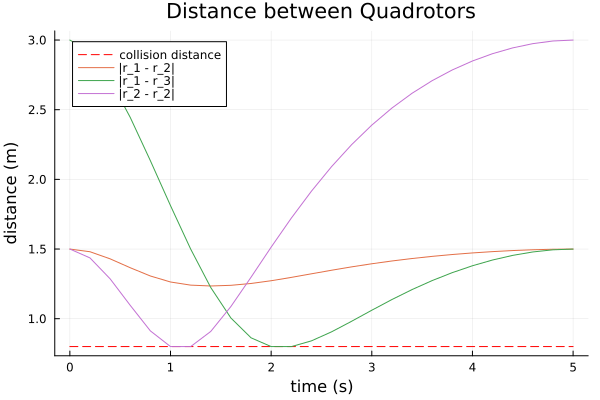

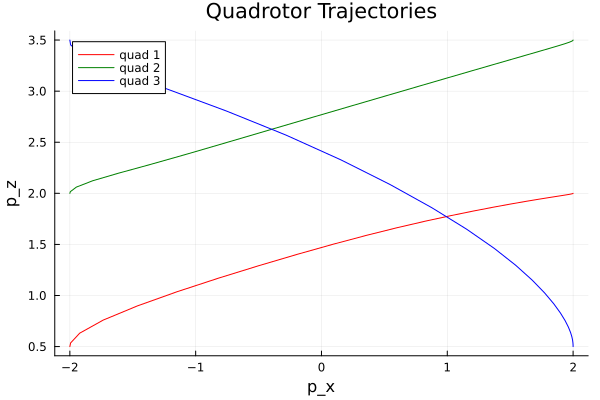

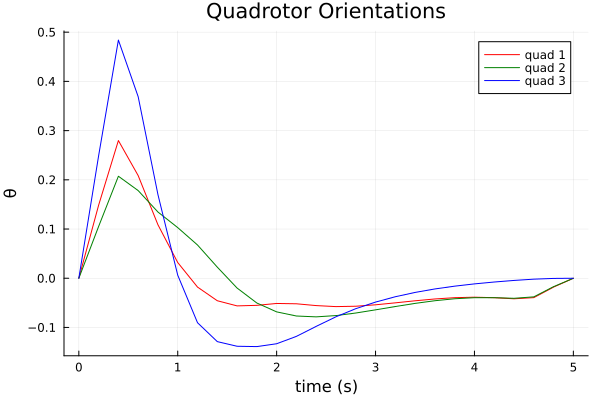

Test Summary:      | Pass  Total   Time
quadrotor reorient |   14     14  25.0s


Test.DefaultTestSet("quadrotor reorient", Any[], 14, false, false, true, 1.742824473417e9, 1.742824498374e9, false, "c:\\CMU\\SEM II\\OCRL\\16745---Optimal-Control-and-Reinforcement-Learning---Spring-2025\\HW3_S25\\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sZmlsZQ==.jl")

In [5]:
@testset "quadrotor reorient" begin 
    
    X1, X2, X3, U1, U2, U3, t_vec, params  = quadrotor_reorient(verbose=true)
    
    
    #---------------testing-----------------
    # check lengths of everything 
    @test length(X1) == length(X2) == length(X3)
    @test length(U1) == length(U2) == length(U3)
    @test length(X1) == params.N 
    @test length(U1) == (params.N-1)
    
    # check for collisions 
    distances = [distance_between_quads(x1[1:2],x2[1:2],x3[1:2]) for (x1,x2,x3) in zip(X1,X2,X3)]
    @test minimum(minimum.(distances)) >= 0.799
    
    # check initial and final conditions 
    @test norm(X1[1] - params.x1ic, Inf) <= 1e-3 
    @test norm(X2[1] - params.x2ic, Inf) <= 1e-3 
    @test norm(X3[1] - params.x3ic, Inf) <= 1e-3 
    @test norm(X1[end] - params.x1g, Inf) <= 2e-1 
    @test norm(X2[end] - params.x2g, Inf) <= 2e-1 
    @test norm(X3[end] - params.x3g, Inf) <= 2e-1 
    
    # check dynamic feasibility 
    @test check_dynamic_feasibility(params,X1,U1)
    @test check_dynamic_feasibility(params,X2,U2)
    @test check_dynamic_feasibility(params,X3,U3)
    
    
    #---------------plotting/animation-------
    display(animate_planar_quadrotors(X1,X2,X3, params.dt))
    
    plot(t_vec, 0.8*ones(params.N),ls = :dash, color = :red, label = "collision distance",
         xlabel = "time (s)", ylabel = "distance (m)", title = "Distance between Quadrotors")
    display(plot!(t_vec, hcat(distances...)', label = ["|r_1 - r_2|" "|r_1 - r_3|" "|r_2 - r_2|"]))
        
    X1m = hcat(X1...)
    X2m = hcat(X2...)
    X3m = hcat(X3...)
    
    plot(X1m[1,:], X1m[2,:], color = :red,title = "Quadrotor Trajectories", label = "quad 1")
    plot!(X2m[1,:], X2m[2,:], color = :green, label = "quad 2",xlabel = "p_x", ylabel = "p_z")
    display(plot!(X3m[1,:], X3m[2,:], color = :blue, label = "quad 3"))
    
    plot(t_vec, X1m[3,:], color = :red,title = "Quadrotor Orientations", label = "quad 1")
    plot!(t_vec, X2m[3,:], color = :green, label = "quad 2",xlabel = "time (s)", ylabel = "θ")
    display(plot!(t_vec, X3m[3,:], color = :blue, label = "quad 3"))
    
    
end